## Import relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms

## Define CoordConv2D Layer

In [2]:
class CoordConv2DLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_tensor):
        _, height, width = input_tensor.size()

        # Create x and y coordinate grids
        xx_channel = torch.arange(width).view(1, 1, 1, width).expand(1, 1, height, width).float() / (width - 1)
        yy_channel = torch.arange(height).view(1, 1, height, 1).expand(1, 1, height, width).float() / (height - 1)

        # Concatenate the coordinate channels to the input tensor
        output_tensor = torch.cat([xx_channel, yy_channel], dim=1)
        return output_tensor

## Define FourierConv2D Layer

In [3]:
class FourierConv2DLayer(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L

    def forward(self, x):
        _, num_input_channels, height, width = x.size()

        # Generate frequencies
        base_frequency = 2
        exponent_value = torch.arange(L)
        frequencies = torch.pow(torch.tensor(base_frequency), exponent_value).float()

        # Apply Fourier basis functions
        fourier_features = [torch.sin(frequencies[j] * torch.pi * x) for j in range(L)]
        fourier_features += [torch.cos(frequencies[j] * torch.pi * x) for j in range(L)]

        # Concatenate the Fourier features along the channel dimension
        fourier_features = torch.cat(fourier_features, dim=1)

        return fourier_features

## Define InverseConv2D Layer

In [4]:
class InverseConv2DLayer(nn.Module):
    def __init__(self, L, num_standard_layers, max_reflectance):
        super().__init__()
        self.L = L
        self.num_fourier_channels = 4*L
        self.num_standard_layers = num_standard_layers
        self.coordinate_layer = CoordConv2DLayer()
        self.fourier_layer = FourierConv2DLayer(L)
        
        self.standard_hidden_layers = nn.ModuleList(
        [nn.Conv2d(self.num_fourier_channels, self.num_fourier_channels, kernel_size=3, padding='same') for _ in range(num_standard_layers)]
        )
        
        self.standard_output_layer = nn.Conv2d(self.num_fourier_channels, 1, kernel_size=3, padding='same')
        
        # Initialize weights with He uniform variance scaling initializer
        for layer in self.standard_hidden_layers:
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_uniform_(self.standard_output_layer.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        output_coordinate = self.coordinate_layer(x)
        output_fourier = self.fourier_layer(output_coordinate)
        
        x = output_fourier
        for layer in self.standard_hidden_layers:
            x = nn.functional.elu(layer(x))
        
        output = max_reflectance * torch.sigmoid(nn.functional.softplus(self.standard_output_layer(x)))
        output_inverse = output

        return output_coordinate, output_fourier, output_inverse

## Instantiate Inverse Layer

In [5]:
L = 4
num_standard_layers = 4
max_reflectance = 0.01
inverse_layer = InverseConv2DLayer(L, num_standard_layers, max_reflectance)

## Apply Inverse Layer to MNIST sample image

### Load MNIST sample image

In [6]:
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
sample_image, label = mnist_train[0]

### Apply Inverse Layer

In [7]:
coordinate_layer_output, fourier_layer_output, inverse_layer_output = inverse_layer(sample_image)

## Check type and shape of Inverse Layer

In [8]:
type(inverse_layer_output)

torch.Tensor

In [9]:
inverse_layer_output.shape

torch.Size([1, 1, 28, 28])

## Visualize Inverse Layer output

### Generate reshaped numpy array for display

In [10]:
inverse_layer_output_plot = inverse_layer_output.squeeze().detach().numpy()

### Check shape of numpy array

In [11]:
inverse_layer_output_plot.shape

(28, 28)

### Generate display

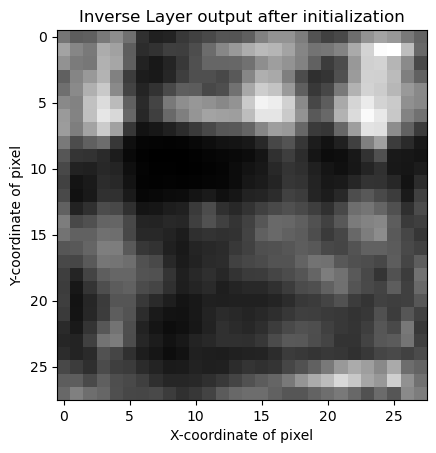

In [12]:
plt.figure()
plt.imshow(inverse_layer_output_plot, cmap='gray')
plt.xlabel('X-coordinate of pixel')
plt.ylabel('Y-coordinate of pixel')
plt.title('Inverse Layer output after initialization')
plt.show()

### Generate meshgrid for surface plot

In [13]:
x, y = np.meshgrid(np.arange(inverse_layer_output_plot.shape[0]), np.arange(inverse_layer_output_plot.shape[1]))

### Generate surface plot

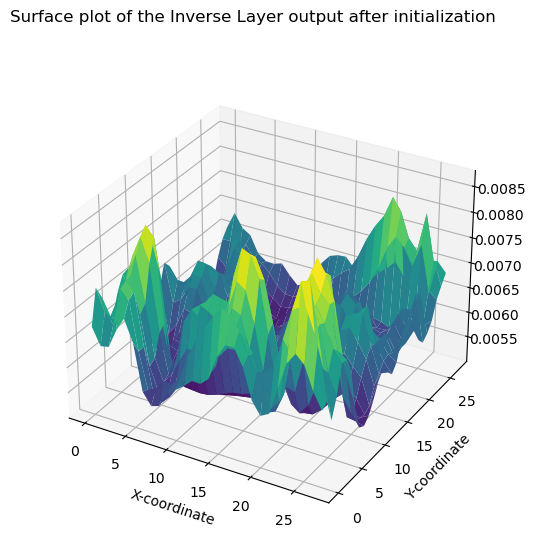

In [14]:
fig= plt.figure(figsize=(10, 6))
fig.suptitle("Surface plot of the Inverse Layer output after initialization")

ax_1 = fig.add_subplot(111, projection='3d')
surface = ax_1.plot_surface(x, y, inverse_layer_output_plot, cmap='viridis')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

plt.show()

## Future work

1. We also want the option to "switch ON and OFF" the "custom layers" (Coordinate and Fourier Layers)
2. We also need to add comments and explanations in this document